# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Delta$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
* [Effect of changes-of-mind](#com)
  * [Mouse-tracking task](#com_mouse)
  * [Walking task](#com_walking)
* [Exploratory analysis](#explore)

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Warning message:
"package 'ggplot2' was built under R version 3.5.2"Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
Warning message:
"package 'reshape2' was built under R version 3.5.2"mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following object

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

Define the functions used throughout the notebook

In [4]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter), ci_inter = ci_inter)
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    }
    return(model)
}

run_analysis <- function(dv, iv, data, rscale){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv). Tscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    print_bf(bf_result, paste(dv, iv, deparse(substitute(data))), iv)
    
    return(bf_result)
}

print_bf <- function(bf_result, analysis_name, iv="Delta"){
    print(analysis_name)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_", iv, ":option_chosenll", sep=""), 
                         paste("b_", iv, ":option_chosenss", sep="")),])

}

spaghetti_plot <- function(model, data, dv, iv, file_name){
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300), plot=FALSE)
    plt <- plt[[1]] + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX("Relative advantage of LL option")) +
        ylab(dv) +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4) 
}

joyplot <- function(model, file_name){
    m <- as.matrix(as.mcmc(model, combine_chains = FALSE))

    # Only keep the choice-by-lambda interaction parameters    
    m <- m[,grep(",option_chosen", colnames(m))]
    
    # Reformat column names
    colnames(m) <- sub("r_subj_id\\[", "s", colnames(m))
    colnames(m) <- sub(",option_chosenss]", "", colnames(m))
    
    # Reorder columns(parameters) by their mean values and plot the result        
    plt <- mcmc_areas_ridges(m[,order(colMeans(m))])#, prob=0.95)
    
    plt <- plt + theme_pander(base_size = 12) +
        xlab("Offset of regression coefficient for SS choices") #+
#         scale_color_manual(values = c("#D55E00", "#0072B2"), guide = "none")
#     +
#        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    ggsave(file.path(figure_path, file_name), dpi=150, width=4, height=8)
}

posterior_plot <- function(model, iv, file_name){
    plot <- mcmc_areas_ridges(as.matrix(as.mcmc(model, combine_chains = TRUE)), 
                              regex_pars = paste("b_", iv, ":option_chosen", sep=""), prob=0.95)
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), file=file.path("posterior_csv", file_name), row.names=FALSE)
}

visualize_model <- function(model, data, task, dv, iv, figure_format){
    spaghetti_plot(model, data, dv, iv, file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format))
    joyplot(model, file_name=sprintf("joy_%s_%s.%s", task, dv, figure_format))
    posterior_plot(model, iv, file_name=sprintf("posterior_%s_%s.%s", task, dv, figure_format))
    save_posterior(model, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
}

# Preregistered analysis <a class="anchor" id="prereg"></a>

## Mouse-tracking task<a class="anchor" id="mouse"></a>

### Mouse-tracking task: max-d<a class="anchor" id="mouse_max_d"></a>

In [23]:
mouse_max_d_bf <- run_analysis("max_d", "Delta", mouse_data, 0.707)
# mouse_max_d_bf_narrow_prior <- run_analysis("max_d", mouse_data, 0.5)
# mouse_max_d_bf_wide_prior <- run_analysis("max_d", mouse_data, 1.0)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 24.702 seconds (Warm-up)
               12.861 seconds (Sampling)
               37.563 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 18.983 seconds (Warm-up)
               10.824 seconds (Sampling)
               29.807 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 4.297 seconds (Warm-up)
               4.064 seconds (Sampling)
               8.361 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [35]:
visualize_model(mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



### Mouse-tracking task: response time<a class="anchor" id="mouse_RT"></a>

In [38]:
mouse_rt_bf <- run_analysis("RT", "Delta", mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 24.683 seconds (Warm-up)
               15.606 seconds (Sampling)
               40.289 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 15.444 seconds (Warm-up)
               9.04 seconds (Sampling)
               24.484 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 4.943 seconds (Warm-up)
               4.418 seconds (Sampling)
               9.361 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [41]:
visualize_model(mouse_rt_bf$models$m_inter, mouse_data, "mouse", "RT", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


## Walking<a class="anchor" id="walking"></a>

### Walking task: max-d<a class="anchor" id="walking_max_d"></a>

In [46]:
walking_max_d_bf <- run_analysis("max_d", "Delta", walking_data, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.388 seconds (Warm-up)
               12.59 seconds (Sampling)
               42.978 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 51.139 seconds (Warm-up)
               15.649 seconds (Sampling)
               66.788 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.23 seconds (Warm-up)
               23.411 seconds (Sampling)
               51.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.649 seconds (Warm-up)
               11.332 seconds (Sampling)
               32.981 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.523 seconds (Warm-up)
               13.859 seconds (Sampling)
               31.382 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.139 seconds (Warm-up)
               8.54 seconds (Sampling)
               29.679 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.408 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.982 seconds (Warm-up)
               2.917 seconds (Sampling)
               9.899 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.885 seconds (Warm-up)
               2.598 seconds (Sampling)
               10.483 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.698 seconds (Warm-up)
               4.432 seconds (Sampling)
               12.13 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.417 seconds

In [50]:
visualize_model(walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


### Walking task: response time<a class="anchor" id="walking_RT"></a>

In [51]:
walking_rt_bf <- run_analysis("RT", "Delta", walking_data, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.913 seconds (Warm-up)
               25.036 seconds (Sampling)
               56.949 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.557 seconds (Warm-up)
               22.386 seconds (Sampling)
               53.943 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.394 seconds (Warm-up)
               22.234 seconds (Sampling)
               54.628 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.98

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.319 seconds (Warm-up)
               15.587 seconds (Sampling)
               38.906 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.221 seconds (Warm-up)
               15.877 seconds (Sampling)
               36.098 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.79 seconds (Warm-up)
               15.789 seconds (Sampling)
               39.579 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.726

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.398 seconds (Warm-up)
               4.367 seconds (Sampling)
               9.765 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.607 seconds (Warm-up)
               4.022 seconds (Sampling)
               8.629 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.01 seconds (Warm-up)
               5.583 seconds (Sampling)
               10.593 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.904 seconds 

In [52]:
visualize_model(walking_rt_bf$models$m_inter, walking_data, "walking", "RT", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Removing the effect of changes-of-mind<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [53]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.965
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.8445
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

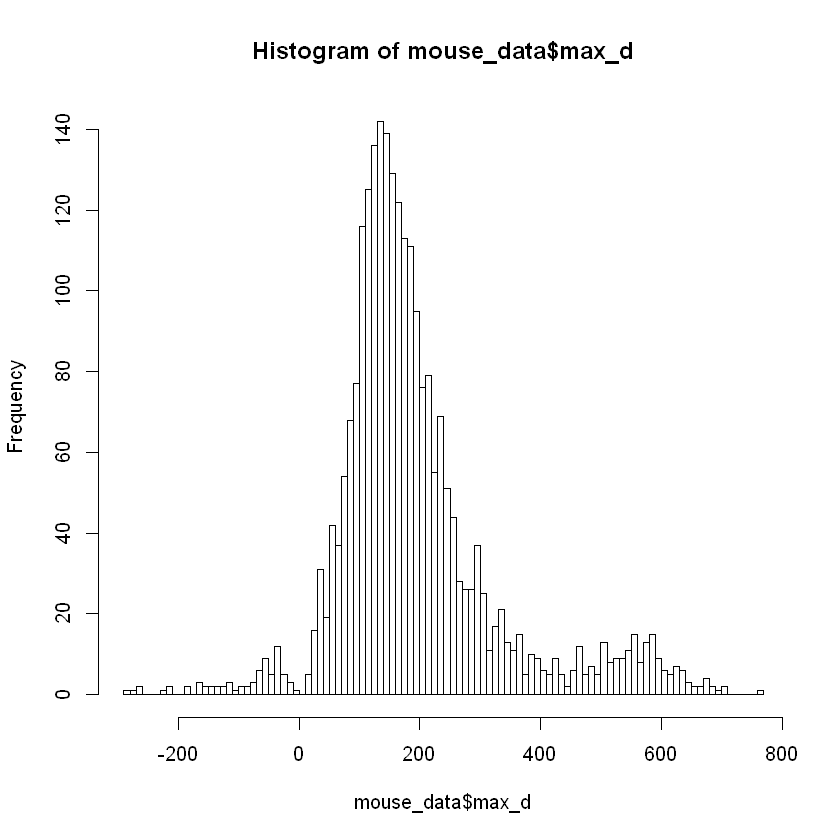

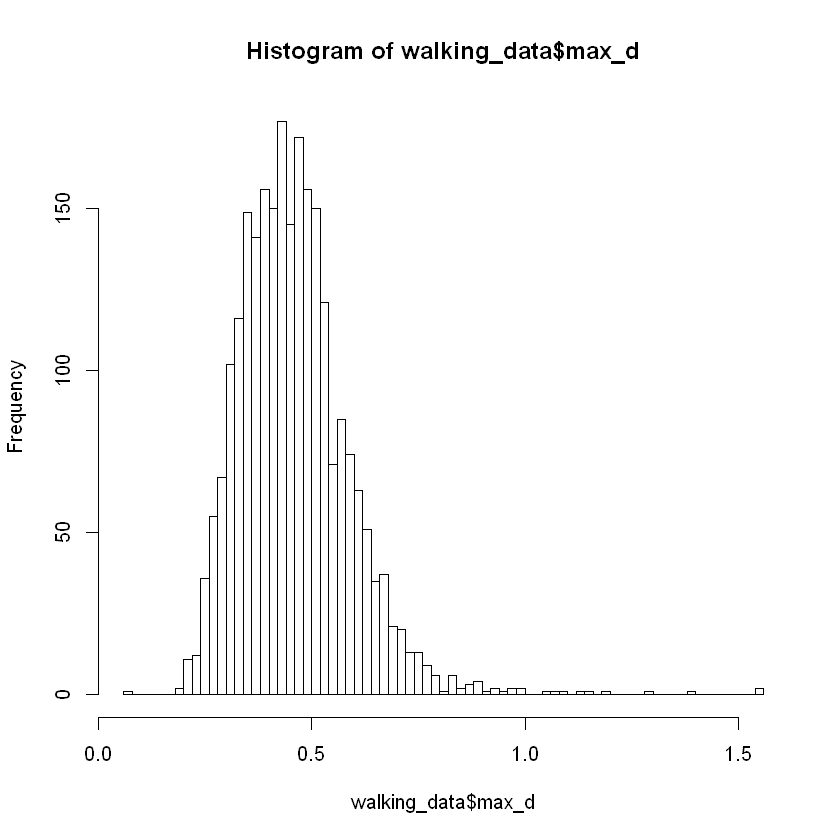

In [54]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [55]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

## Effects of CoM: mouse-tracking task<a class="anchor" id="com_mouse"></a>

In [56]:
mouse_max_d_no_com_bf <- run_analysis("max_d", "Delta", mouse_data_no_com, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.873 seconds (Warm-up)
               16.789 seconds (Sampling)
               38.662 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.56 seconds (Warm-up)
               19.701 seconds (Sampling)
               45.261 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.936 seconds (Warm-up)
               11.757 seconds (Sampling)
               34.693 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.51 seconds (Warm-up)
               13.673 seconds (Sampling)
               29.183 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.718 seconds (Warm-up)
               12.382 seconds (Sampling)
               35.1 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.829 seconds (Warm-up)
               13.486 seconds (Sampling)
               31.315 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.161 seconds (Warm-up)
               4.04 seconds (Sampling)
               10.201 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.711 seconds (Warm-up)
               4.048 seconds (Sampling)
               9.759 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.652 seconds (Warm-up)
               4.055 seconds (Sampling)
               9.707 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.94 seco

In [57]:
visualize_model(mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                "mouse_no_com", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [6]:
mouse_rt_no_com_bf <- run_analysis("RT", "Delta", mouse_data_no_com, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.144 seconds (Warm-up)
               16.078 seconds (Sampling)
               35.222 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.543 seconds (Warm-up)
               10.239 seconds (Sampling)
               30.782 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.601 seconds (Warm-up)
               9.968 seconds (Sampling)
               30.569 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.98 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.379 seconds (Warm-up)
               7.844 seconds (Sampling)
               23.223 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 12.945 seconds (Warm-up)
               11.2 seconds (Sampling)
               24.145 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 14.319 seconds (Warm-up)
               13.525 seconds (Sampling)
               27.844 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.306 s

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.301 seconds (Warm-up)
               2.118 seconds (Sampling)
               6.419 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.125 seconds (Warm-up)
               3.013 seconds (Sampling)
               7.138 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.1 seconds (Warm-up)
               2.033 seconds (Sampling)
               5.133 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.449 seconds (W

In [7]:
visualize_model(mouse_rt_no_com_bf$models$m_inter, mouse_data_no_com, 
                "mouse_no_com", "RT", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


## Effects of CoM: walking task<a class="anchor" id="com_walking"></a>

In [58]:
walking_max_d_no_com_bf <- run_analysis("max_d", "Delta", walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.473 seconds (Warm-up)
               12.82 seconds (Sampling)
               45.293 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.882 seconds (Warm-up)
               14.113 seconds (Sampling)
               44.995 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.884 seconds (Warm-up)
               20.508 seconds (Sampling)
               52.392 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.37 seconds (Warm-up)
               8.39 seconds (Sampling)
               29.76 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.894 seconds (Warm-up)
               16.183 seconds (Sampling)
               45.077 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.517 seconds (Warm-up)
               9.531 seconds (Sampling)
               35.048 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.234 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.307 seconds (Warm-up)
               3.926 seconds (Sampling)
               14.233 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.728 seconds (Warm-up)
               4.266 seconds (Sampling)
               11.994 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.134 seconds (Warm-up)
               3.67 seconds (Sampling)
               10.804 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.843 secon

In [59]:
visualize_model(walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                "walking_no_com", "max_d", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [8]:
walking_rt_no_com_bf <- run_analysis("RT", "Delta", walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.214 seconds (Warm-up)
               21.338 seconds (Sampling)
               56.552 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.962 seconds (Warm-up)
               21.382 seconds (Sampling)
               51.344 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.336 seconds (Warm-up)
               41.583 seconds (Sampling)
               77.919 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.625 seconds (Warm-up)
               15.296 seconds (Sampling)
               37.921 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.438 seconds (Warm-up)
               15.905 seconds (Sampling)
               38.343 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.74 seconds (Warm-up)
               17.138 seconds (Sampling)
               39.878 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.883

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.809 seconds (Warm-up)
               4.396 seconds (Sampling)
               9.205 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.827 seconds (Warm-up)
               4.759 seconds (Sampling)
               10.586 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.968 seconds (Warm-up)
               4.778 seconds (Sampling)
               10.746 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.615 second

In [9]:
visualize_model(walking_rt_no_com_bf$models$m_inter, walking_data_no_com, 
                "walking_no_com", "RT", "Delta", figure_format)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Effect of $\lambda$

In [22]:
run_all_analyses <- function(iv){
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, 0.707)
    visualize_model(mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", iv, figure_format)
    
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, 0.707)
    visualize_model(mouse_rt_bf$models$m_inter, mouse_data, "mouse", "RT", iv, figure_format)
    
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, 0.707)
    visualize_model(walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", iv, figure_format)
    
    walking_rt_bf <- run_analysis("RT", iv, walking_data, 0.707)
    visualize_model(walking_rt_bf$models$m_inter, walking_data, "walking", "RT", iv, figure_format)
    
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, 0.707)    
    visualize_model(mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, 0.707)    
    visualize_model(mouse_rt_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format) 
    
    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, 0.707)
    visualize_model(walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, 0.707)
    visualize_model(walking_rt_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
        
    return(list(mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf, 
                walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf,
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf))
}

lambda_results <- run_all_analyses("Lambda")

print_bf(lambda_results$mouse_max_d_bf, "mouse task max-d lambda analysis", "Lambda")
print_bf(lambda_results$mouse_rt_bf, "mouse task RT lambda analysis", "Lambda")
print_bf(lambda_results$walking_max_d_bf, "walking task max-d lambda analysis", "Lambda")
print_bf(lambda_results$walking_rt_bf, "walking task RT lambda analysis", "Lambda")    

print_bf(lambda_results$mouse_max_d_no_com_bf, "mouse task max-d lambda no CoM analysis", "Lambda")
print_bf(lambda_results$mouse_rt_no_com_bf, "mouse task RT lambda no CoM analysis", "Lambda")
print_bf(lambda_results$walking_max_d_no_com_bf, "walking task max-d lambda no CoM analysis", "Lambda")
print_bf(lambda_results$walking_rt_no_com_bf, "walking task RT lambda no CoM analysis", "Lambda")

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.577 seconds (Warm-up)
               22.613 seconds (Sampling)
               46.19 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.949 seconds (Warm-up)
               22.528 seconds (Sampling)
               46.477 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.46 seconds (Warm-up)
               11.648 seconds (Sampling)
               36.108 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.675 seconds (Warm-up)
               12.627 seconds (Sampling)
               32.302 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.929 seconds (Warm-up)
               8.132 seconds (Sampling)
               25.061 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.038 seconds (Warm-up)
               8.76 seconds (Sampling)
               25.798 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.001 seconds (Warm-up)
               2.39 seconds (Sampling)
               8.391 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.6 seconds (Warm-up)
               4.378 seconds (Sampling)
               9.978 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.184 seconds (Warm-up)
               4.506 seconds (Sampling)
               10.69 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.331 second

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.38 seconds (Warm-up)
               24.509 seconds (Sampling)
               53.889 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.571 seconds (Warm-up)
               26.258 seconds (Sampling)
               56.829 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.042 seconds (Warm-up)
               22.234 seconds (Sampling)
               52.276 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.695 seconds (Warm-up)
               9.092 seconds (Sampling)
               24.787 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.035 seconds (Warm-up)
               14.111 seconds (Sampling)
               33.146 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.836 seconds (Warm-up)
               13.115 seconds (Sampling)
               28.951 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.711

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.137 seconds (Warm-up)
               4.749 seconds (Sampling)
               9.886 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.76 seconds (Warm-up)
               4.749 seconds (Sampling)
               9.509 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.895 seconds (Warm-up)
               4.409 seconds (Sampling)
               9.304 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.414 seco

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.972 seconds (Warm-up)
               21.919 seconds (Sampling)
               52.891 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.443 seconds (Warm-up)
               13.703 seconds (Sampling)
               40.146 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.013 seconds (Warm-up)
               21.982 seconds (Sampling)
               55.995 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.39

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.438 seconds (Warm-up)
               10.027 seconds (Sampling)
               32.465 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.009 seconds (Warm-up)
               12.594 seconds (Sampling)
               32.603 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.715 seconds (Warm-up)
               11.959 seconds (Sampling)
               32.674 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.01

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.925 seconds (Warm-up)
               4.356 seconds (Sampling)
               10.281 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.553 seconds (Warm-up)
               4.323 seconds (Sampling)
               12.876 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.237 seconds (Warm-up)
               2.197 seconds (Sampling)
               9.434 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.106 second

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.128 seconds (Warm-up)
               24.285 seconds (Sampling)
               57.413 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.319 seconds (Warm-up)
               21.569 seconds (Sampling)
               54.888 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.166 seconds (Warm-up)
               26.678 seconds (Sampling)
               59.844 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.46

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.943 seconds (Warm-up)
               29.899 seconds (Sampling)
               52.842 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.072 seconds (Warm-up)
               16.188 seconds (Sampling)
               40.26 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.861 seconds (Warm-up)
               15.619 seconds (Sampling)
               38.48 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.805 

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.923 seconds (Warm-up)
               4.342 seconds (Sampling)
               9.265 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.41 seconds (Warm-up)
               8.42 seconds (Sampling)
               13.83 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.965 seconds (Warm-up)
               7.978 seconds (Sampling)
               13.943 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.264 seconds (

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.916 seconds (Warm-up)
               19.663 seconds (Sampling)
               41.579 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.898 seconds (Warm-up)
               12.543 seconds (Sampling)
               40.441 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.463 seconds (Warm-up)
               13.857 seconds (Sampling)
               40.32 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.316 seconds (Warm-up)
               8.18 seconds (Sampling)
               24.496 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.904 seconds (Warm-up)
               14.218 seconds (Sampling)
               33.122 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.307 seconds (Warm-up)
               9.392 seconds (Sampling)
               29.699 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 14.184 s

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.761 seconds (Warm-up)
               4.027 seconds (Sampling)
               8.788 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.549 seconds (Warm-up)
               2.868 seconds (Sampling)
               8.417 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.114 seconds (Warm-up)
               3.619 seconds (Sampling)
               8.733 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.178 seconds 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.609 seconds (Warm-up)
               20.079 seconds (Sampling)
               46.688 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.301 seconds (Warm-up)
               21.137 seconds (Sampling)
               50.438 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.566 seconds (Warm-up)
               18.667 seconds (Sampling)
               45.233 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.34

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.166 seconds (Warm-up)
               13.479 seconds (Sampling)
               28.645 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 14.273 seconds (Warm-up)
               11.283 seconds (Sampling)
               25.556 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.483 seconds (Warm-up)
               12.893 seconds (Sampling)
               28.376 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 14.45

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.384 seconds (Warm-up)
               4.115 seconds (Sampling)
               8.499 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.736 seconds (Warm-up)
               3.626 seconds (Sampling)
               7.362 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.746 seconds (Warm-up)
               4.081 seconds (Sampling)
               8.827 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.31 seconds (

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.585 seconds (Warm-up)
               23.323 seconds (Sampling)
               59.908 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.243 seconds (Warm-up)
               14.149 seconds (Sampling)
               49.392 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 48.498 seconds (Warm-up)
               18.709 seconds (Sampling)
               67.207 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.74

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.154 seconds (Warm-up)
               8.86 seconds (Sampling)
               31.014 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.267 seconds (Warm-up)
               14.868 seconds (Sampling)
               36.135 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.966 seconds (Warm-up)
               10.867 seconds (Sampling)
               31.833 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.379 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.956 seconds (Warm-up)
               6.068 seconds (Sampling)
               14.024 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.095 seconds (Warm-up)
               3.953 seconds (Sampling)
               12.048 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.779 seconds (Warm-up)
               4.195 seconds (Sampling)
               11.974 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 9.664 secon

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.048 seconds (Warm-up)
               22.185 seconds (Sampling)
               59.233 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.522 seconds (Warm-up)
               32.326 seconds (Sampling)
               70.848 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.763 seconds (Warm-up)
               22.054 seconds (Sampling)
               52.817 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.32

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.802 seconds (Warm-up)
               15.863 seconds (Sampling)
               38.665 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.167 seconds (Warm-up)
               17.226 seconds (Sampling)
               42.393 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.627 seconds (Warm-up)
               16.754 seconds (Sampling)
               41.381 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.901 seconds (Warm-up)
               4.37 seconds (Sampling)
               9.271 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.807 seconds (Warm-up)
               4.644 seconds (Sampling)
               9.451 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.753 seconds (Warm-up)
               4.667 seconds (Sampling)
               10.42 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.052 seconds (

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "mouse task max-d lambda analysis"
[1] "BF of choice model over null model: 2.96549e+74"
[1] "BF of choice-by-delta model over null model: 2.68863e+75"
[1] "BF of choice-by-delta model over choice-only model: 8.98548"
                              lower     upper
b_Lambda:option_chosenll -11.218003 -3.770717
b_Lambda:option_chosenss  -1.933067  4.618961
[1] "mouse task RT lambda analysis"
[1] "BF of choice model over null model: 1.00679e+08"
[1] "BF of choice-by-delta model over null model: 2.82883e+19"
[1] "BF of choice-by-delta model over choice-only model: 2.9449e+11"
                               lower       upper
b_Lambda:option_chosenll -0.15145158 -0.07744219
b_Lambda:option_chosenss  0.06866046  0.13029267
[1] "walking task max-d lambda analysis"
[1] "BF of choice model over null model: 7.74145e+67"
[1] "BF of choice-by-delta model over null model: 2.50419e+76"
[1] "BF of choice-by-delta model over choice-only model: 2.90041e+08"
                                lower      

# Generate latex table

In [10]:
hyp_1_format_string <- "\\begin{table}[]
\\caption{%s}
\\label{%s}
\\begin{tabular}{@{}llll@{}}
\\toprule
 &  & max-d & RT \\\\ \\midrule
\\multirow{2}{*}{mouse-tracking} & All data & %.6g & %.6g \\\\
 & CoM excluded &  %.6g & %.6g \\\\
\\multirow{2}{*}{walking} & All data & %.6g & %.6g \\\\
 & CoM excluded & %.6g & %.6g \\\\ \\cmidrule(l){1-4} 
\\end{tabular}
\\end{table}"

In [20]:
caption = "Results of testing Hypothesis 1 for the walking and mouse-tracking tasks"
label = "tab:hyp_1_bf"
output <- sprintf(hyp_1_format_string, caption, label, 
                  mouse_max_d_bf$bf[3], mouse_rt_bf$bf[3],
                  mouse_max_d_no_com_bf$bf[3], mouse_rt_no_com_bf$bf[3],
                  walking_max_d_bf$bf[3], walking_rt_bf$bf[3],
                  walking_max_d_no_com_bf$bf[3], walking_rt_no_com_bf$bf[3]
                 )

fileConn<-file(file.path(table_path, "hyp_1_delta.tex"))
writeLines(output, fileConn)
close(fileConn)

In [24]:
caption = "Results of testing Hypothesis 1 for the walking and mouse-tracking tasks (using $\\lambda$ instead of $\\Delta$)"
label = "tab:hyp_1_bf_lambda"
output <- sprintf(hyp_1_format_string, caption, label, 
                  lambda_results$mouse_max_d_bf$bf[3], lambda_results$mouse_rt_bf$bf[3],
                  lambda_results$mouse_max_d_no_com_bf$bf[3], lambda_results$mouse_rt_no_com_bf$bf[3],
                  lambda_results$walking_max_d_bf$bf[3], lambda_results$walking_rt_bf$bf[3],
                  lambda_results$walking_max_d_no_com_bf$bf[3], lambda_results$walking_rt_no_com_bf$bf[3]
                 )

fileConn<-file(file.path(table_path, "hyp_1_lambda.tex"))
writeLines(output, fileConn)
close(fileConn)

# Save all results to RData file

In [23]:
save.image()